# Orginal Code KOmmentiert:
Node: Knotenstruktur zur Speicherung von Position, Kosten und Verweisen.
planning: Hauptfunktion, die den A*-Algorithmus implementiert.
calc_heuristic: Berechnet die heuristische Distanz.
verify_node: Prüft, ob ein Knoten gültig und frei von Hindernissen ist.
get_motion_model: Gibt Bewegungsoptionen für den Roboter zurück.

MO_Astar.py start!!
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35


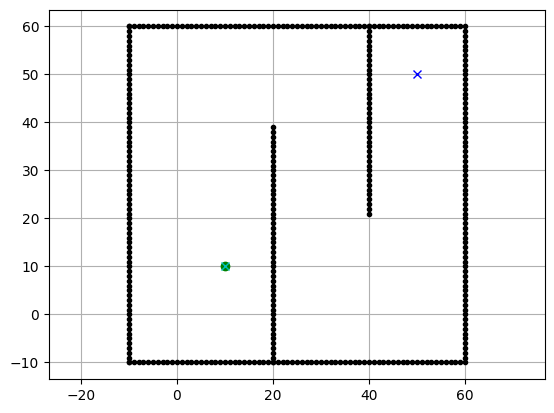

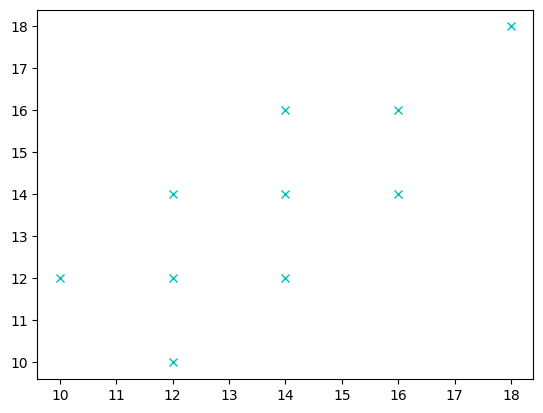

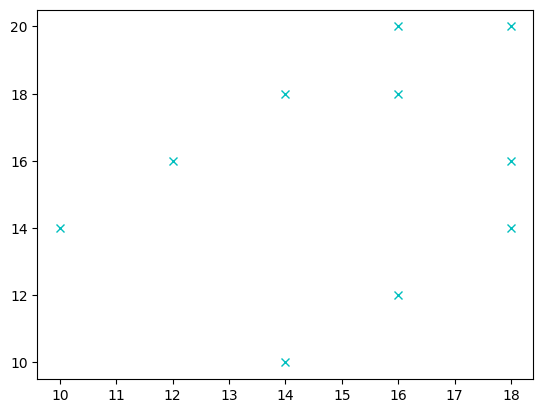

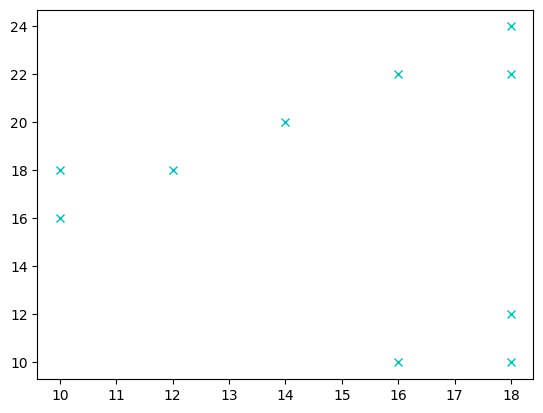

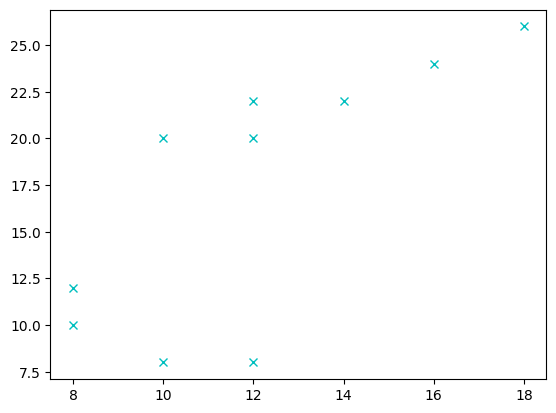

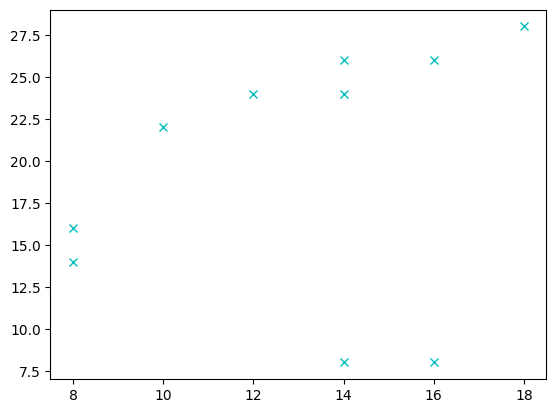

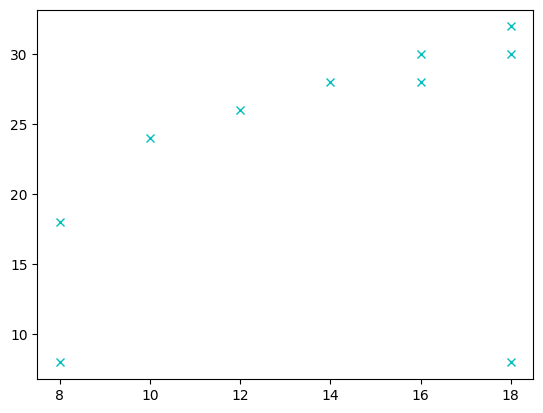

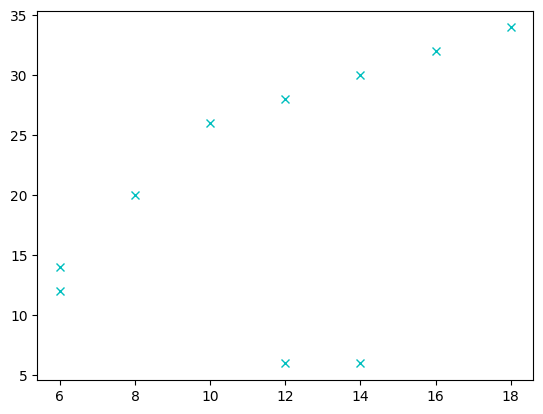

KeyboardInterrupt: 

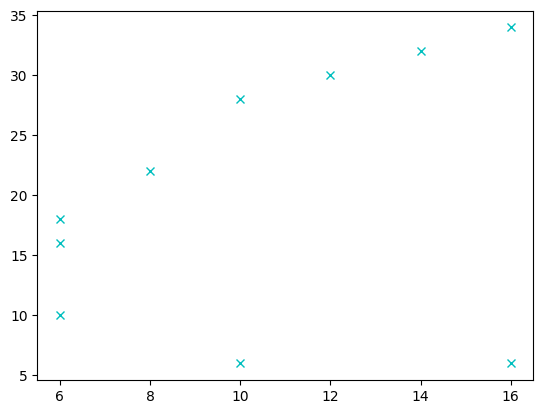

In [11]:
"""
A* grid planning

author: Atsushi Sakai(@Atsushi_twi)
        Nikos Kanargias (nkana@tee.gr)

See Wikipedia article (https://en.wikipedia.org/wiki/A*_search_algorithm)
"""

import math
import matplotlib.pyplot as plt

show_animation = True  # Aktiviert die Visualisierung der Pfadsuche


class AStarPlanner:
    def __init__(self, ox, oy, resolution, rr):
        """
        Initialisiert die A*-Planungsumgebung.

        ox: x-Koordinaten der Hindernisse [m]
        oy: y-Koordinaten der Hindernisse [m]
        resolution: Gitterauflösung [m]
        rr: Roboter-Radius [m] (für den Sicherheitsabstand zu Hindernissen)
        """
        self.resolution = resolution  # Auflösung des Gitters
        self.rr = rr  # Sicherheitsabstand um den Roboter
        self.min_x, self.min_y = 0, 0  # Minimale x- und y-Werte
        self.max_x, self.max_y = 0, 0  # Maximale x- und y-Werte
        self.obstacle_map = None  # Karte der Hindernisse
        self.x_width, self.y_width = 0, 0  # Gitterbreite und -höhe
        self.motion = self.get_motion_model()  # Bewegungsmodell
        self.calc_obstacle_map(ox, oy)  # Hinderniskarte berechnen

    class Node:
        """Repräsentiert einen Knoten im A*-Suchbaum."""
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # x-Index im Gitter
            self.y = y  # y-Index im Gitter
            self.cost = cost  # Kosten bis zu diesem Knoten
            self.parent_index = parent_index  # Index des Elternknotens (für die Pfadrekonstruktion)

        def __str__(self):
            # Gibt die Knotendaten als String aus (für Debugging)
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        Führt die A*-Pfadplanung aus.

        sx, sy: Startposition (x, y) in Metern
        gx, gy: Zielposition (x, y) in Metern
        """
        # Start- und Zielknoten berechnen
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()  # Offene und geschlossene Listen
        open_set[self.calc_grid_index(start_node)] = start_node  # Startknoten zur offenen Liste hinzufügen

        while True:
            if len(open_set) == 0:  # Abbruchbedingung: Kein Pfad gefunden
                print("Open set is empty..")
                break

            # Wähle den Knoten mit den geringsten f-Kosten (g + h)
            c_id = min(open_set, key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node, open_set[o]))
            current = open_set[c_id]

            # Animation der aktuellen Suche
            if show_animation:
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            # Zielbedingung: Zielknoten erreicht
            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Knoten aus der offenen Liste entfernen und zur geschlossenen Liste hinzufügen
            del open_set[c_id]
            closed_set[c_id] = current

            # Nachbarn des aktuellen Knotens generieren
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # Überprüfen, ob der Knoten gültig ist
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:  # Überspringe bereits besuchte Knoten
                    continue

                if n_id not in open_set:   
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node  # Update node

        # Pfad vom Ziel zurück zum Start rekonstruieren
        rx, ry = self.calc_final_path(goal_node, closed_set)
        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        """
        Rekonstruiert den finalen Pfad aus der geschlossenen Liste.
        """
        # Initialisiere die Pfadlisten mit der Position des Zielknotens
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        # Gehe durch die Elternknoten, bis der Startknoten erreicht ist
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index
        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        """
        Berechnet die heuristische Distanz zwischen zwei Knoten.
        """
        w = 1.0  # Gewichtung der Heuristik
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)  # Euklidische Distanz
        return d
    
    def calc_grid_position(self, index, min_position):
        """
        Berechnet die Position im Gitter basierend auf dem Index.
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        """
        Berechnet den Gitterindex basierend auf der Position.
        """
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        """
        Berechnet einen einzigartigen Index für einen Knoten basierend auf seiner Position.
        """
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        """
        Überprüft, ob ein Knoten gültig ist (innerhalb des Gitters und kein Hindernis).
        """
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        # Überprüfen, ob der Knoten innerhalb der Gittergrenzen liegt
        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # Überprüfen, ob der Knoten ein Hindernis ist
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):
        """
        Erstellt eine Hinderniskarte basierend auf Hindernispositionen.
        """
        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # Initialisiere die Hinderniskarte
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        """
        Definiert Bewegungsmöglichkeiten: Geradeaus, Diagonal mit Kosten.
        """
        # dx, dy, cost
        motion = [[1, 0, 1],  # Rechts
                  [0, 1, 1],  # Hoch
                  [-1, 0, 1],  # Links
                  [0, -1, 1],  # Runter
                  [-1, -1, math.sqrt(2)],  # Diagonal links unten
                  [-1, 1, math.sqrt(2)],  # Diagonal links oben
                  [1, -1, math.sqrt(2)],  # Diagonal rechts unten
                  [1, 1, math.sqrt(2)]]  # Diagonal rechts oben

        return motion

def main():
    """
    Hauptfunktion zur Ausführung der A*-Pfadplanung mit Visualisierung.
    """
    print("MO_Astar.py start!!")
    sx = 10.0  # [m]
    sy = 10.0  # [m]  # Startposition
    gx = 50.0  # [m]
    gy = 50.0  # [m] # Zielposition
    grid_size = 2.0  # [m]
    robot_radius = 1.0  # [m] # Gitterauflösung und Robotergröße


    # Hindernisse definieren (Begrenzung und Blockaden)
    ox, oy = [], []  # Hindernisliste erstellen
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)

    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "og")
        plt.plot(gx, gy, "xb")
        plt.grid(True)
        plt.axis("equal")

    a_star = AStarPlanner(ox, oy, grid_size, robot_radius)
    rx, ry = a_star.planning(sx, sy, gx, gy)

    if show_animation:  # pragma: no cover
        plt.plot(rx, ry, "-r")
        plt.pause(0.001)
        plt.show()


if __name__ == '__main__':
    main()


Test Ausgabe Jubiter

Erster Versuch Chat_GPT

In [10]:
import math
from a_star import AStarPlanner
import matplotlib.pyplot as plt

show_animation = True

class MOAStarPlanner(AStarPlanner):
    def __init__(self, ox, oy, resolution, rr, w1=1.0, w2=1.0, w3=1.0):
        """
        Multi-Objective A* Planner

        :param ox: x position list of obstacles
        :param oy: y position list of obstacles
        :param resolution: grid resolution
        :param rr: robot radius
        :param w1: weight for path length
        :param w2: weight for clearance
        :param w3: weight for energy cost
        """
        super().__init__(ox, oy, resolution, rr)
        self.ox = ox  # Speichere die x-Koordinaten der Hindernisse
        self.oy = oy  # Speichere die y-Koordinaten der Hindernisse
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def calc_clearance(self, node):
        """
        Calculate clearance cost as inverse distance to the nearest obstacle.
        """
        min_distance = float('inf')
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)
        for ox, oy in zip(self.ox, self.oy):
            d = math.hypot(ox - px, oy - py)
            if d < min_distance:
                min_distance = d
        return min_distance if min_distance > 0 else 1.0  # Avoid division by zero

    def calc_energy_cost(self, current, neighbor):
        """
        Calculate energy cost based on turn angles.
        """
        if current.parent_index == -1:  # No parent, first node
            return 0.0

        parent = self.closed_set[current.parent_index]
        angle1 = math.atan2(current.y - parent.y, current.x - parent.x)
        angle2 = math.atan2(neighbor.y - current.y, neighbor.x - current.x)
        turn_angle = abs(angle2 - angle1)
        return turn_angle

    def update_node_cost(self, current, neighbor):
        """
        Update the cost of a node based on multi-objective optimization.
        """
        move_cost = self.motion[0][2]  # Assuming uniform move cost
        clearance_cost = 1.0 / self.calc_clearance(neighbor)  # Inverse of clearance
        energy_cost = self.calc_energy_cost(current, neighbor)

        total_cost = (current.cost + move_cost +
                      self.w1 * move_cost +
                      self.w2 * clearance_cost +
                      self.w3 * energy_cost)
        return total_cost

    def planning(self, sx, sy, gx, gy):
        """
        Multi-Objective A* Path Planning
        """
        self.closed_set = dict()
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set = dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while True:
            if len(open_set) == 0:
                print("Open set is empty. No solution.")
                break

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)



            # Select node with minimum cost
            c_id = min(open_set, key=lambda o: open_set[o].cost +
                       self.calc_heuristic(goal_node, open_set[o]))
            current = open_set[c_id]

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            del open_set[c_id]
            self.closed_set[c_id] = current

            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 0.0, c_id)
                n_id = self.calc_grid_index(node)
                if not self.verify_node(node):
                    continue

                if n_id in self.closed_set:
                    continue

                new_cost = self.update_node_cost(current, node)

                if n_id not in open_set or open_set[n_id].cost > new_cost:
                    node.cost = new_cost
                    open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, self.closed_set)
        return rx, ry

def main():
    print("Multi-Objective A* Path Planning")

    # Start and goal positions
    sx, sy = 10.0, 10.0
    gx, gy = 50.0, 50.0
    grid_size = 2.0
    robot_radius = 1.0

    # Set obstacle positions
    ox, oy = [], []
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)

    # Run Multi-Objective A*
    mo_a_star = MOAStarPlanner(ox, oy, grid_size, robot_radius, w1=1.0, w2=2.0, w3=0.5)
    rx, ry = mo_a_star.planning(sx, sy, gx, gy)

    # Visualization
    if True:
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "og")
        plt.plot(gx, gy, "xb")
        plt.plot(rx, ry, "-r")
        plt.grid(True)
        plt.axis("equal")
        plt.show()

if __name__ == '__main__':
    main()


Multi-Objective A* Path Planning
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35


UnboundLocalError: cannot access local variable 'current' where it is not associated with a value